In [1]:
!pip install flair
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 5.7 MB/s 
     |████████████████████████████████| 1.6 MB 25.2 MB/s 
     |████████████████████████████████| 788 kB 38.2 MB/s 
     |████████████████████████████████| 46 kB 2.6 MB/s 
     |████████████████████████████████| 101 kB 9.3 MB/s 
     |████████████████████████████████| 1.2 MB 6.8 MB/s 
     |████████████████████████████████| 53 kB 543 kB/s 
     |████████████████████████████████| 19.7 MB 5.8 MB/s 
     |████████████████████████████████| 981 kB 37.7 MB/s 
     |████████████████████████████████| 4.4 MB 37.8 MB/s 
     |████████████████████████████████| 199 kB 32.2 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 6.6 MB 32.6 MB/s 
     |████████████████████████████████| 596 kB 33.9 MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-py3-none-any.whl size=116702 sha256=6dcc7bb14364b821

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import sys
sys.path.append("/content/drive/MyDrive/HADR - Pingjing and Ly/code/")

In [4]:
!mkdir -p /root/.flair/models/
!cp -R /content/drive/MyDrive/HADR\ -\ Pingjing\ and\ Ly/code/ner-english-ontonotes-fast /root/.flair/models/

In [5]:
import pandas as pd
from collections import defaultdict
import py_relex
from py_relex import CoNetwork, DepNetwork, ConstNetwork
from py_relex import FlairNER, SpacyNER
from py_relex import spacy_flair_intersection, spacy_flair_union, tagged_tokens_2_rels

2022-06-21 20:05:36,242 loading file /root/.flair/models/ner-english-ontonotes-fast/0d55dd3b912da9cf26e003035a0c269a0e9ab222f0be1e48a3bbba3a58c0fed0.c9907cd5fde3ce84b71a4172e7ca03841cd81ab71d13eb68aa08b259f57c00b6


/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


2022-06-21 20:05:54,531 SequenceTagger predicts: Dictionary with 76 tags: <unk>, O, B-CARDINAL, E-CARDINAL, S-PERSON, S-CARDINAL, S-PRODUCT, B-PRODUCT, I-PRODUCT, E-PRODUCT, B-WORK_OF_ART, I-WORK_OF_ART, E-WORK_OF_ART, B-PERSON, E-PERSON, S-GPE, B-DATE, I-DATE, E-DATE, S-ORDINAL, S-LANGUAGE, I-PERSON, S-EVENT, S-DATE, B-QUANTITY, E-QUANTITY, S-TIME, B-TIME, I-TIME, E-TIME, B-GPE, E-GPE, S-ORG, I-GPE, S-NORP, B-FAC, I-FAC, E-FAC, B-NORP, E-NORP, S-PERCENT, B-ORG, E-ORG, B-LANGUAGE, E-LANGUAGE, I-CARDINAL, I-ORG, S-WORK_OF_ART, I-QUANTITY, B-MONEY


In [ ]:
# tagged_tokens_path = "/content/drive/MyDrive/HADR - Pingjing and Ly/code/py_relex/example_data/ore_tagged_tokens.csv"
# gt_relations_path = "/content/drive/MyDrive/HADR - Pingjing and Ly/code/py_relex/example_data/ore_gt_relations.csv"

In [ ]:
# tagged_tokens_path = "/content/drive/MyDrive/HADR - Pingjing and Ly/april_18/irma_sitreps_tagged_tokens.csv"
# gt_relations_path = "/content/drive/MyDrive/HADR - Pingjing and Ly/april_18/irma_sitreps_rel.csv"

In [ ]:
NEGATIVE_FLAG = "no_relation"
rel_headers = ["sent_idx", "sent_text", "rel_type", "ent1_text", "ent2_text", "ent1_type", "ent2_type", "ent1_id", "ent2_id", "in_between_text", "sdp_dist", "sdp_path", "sdp_dep_pos", "const_pos"]

# Prepare features and rules

In [27]:
def rule_0(gt):
    if gt=="no_relation":
        return 0
    else:
        return 1

# Sitreps

In [28]:
def rule_1(dep):
    if len(dep)>=2 and len(dep)<=16:
        if len(set(dep))==1 and dep[0]=="PROPN":
            return 1
    return 0

def rule_2(dep):
    ptn = ["VERB", "ADP", "PROPN"]
    if " ".join(ptn) in " ".join(dep):
        return 1
    return 0

def rule_3(dep):
    ptn = ["VERB", "NOUN"]
    if " ".join(ptn) in " ".join(dep):
        return 1
    return 0

# def rule_3(dep):
#     ptn = ["VERB", "NOUN"]
#     if " ".join(ptn) in " ".join(dep):
#         return 1
#     return 0    

def rule_4(const):
    if len(const)>=1 and len(const)<=8:
        if len(set(const))==1 and const[0]=="PROPN":
            return 1
    return 0

def rule_5(const):
    # if "CCONJ" == const[0]:
    if "CCONJ" in const:
        return 1
    return 0

def rule_6(const):
    if "ADP" in const:
        return 1
    return 0

def rule_7(co_dist):
    if co_dist in [1, 2, 3, 4, 5]: # increased to top 5 
        return 1
    return 0

def rule_8(dep_dist):
    if dep_dist in [1, 3, 4, 5, 6]:
        return 1
    return 0

In [29]:
# for gt data
sitreps_tagged_tokens_path = "/content/drive/MyDrive/HADR - Pingjing and Ly/april_16/sitreps_tagged_tokens.csv"
sitreps_gt_relations_path = "/content/drive/MyDrive/HADR - Pingjing and Ly/april_16/sitreps_gt_relations_0417.csv"

sitreps_tagged_tokens = pd.read_csv(sitreps_tagged_tokens_path, keep_default_na=False, dtype={'human_annotation_ent_id': str}).values.tolist()
sitreps_gt_relations = pd.read_csv(sitreps_gt_relations_path, keep_default_na=False).values.tolist()

potential_rels = tagged_tokens_2_rels(sitreps_tagged_tokens)
gt_tf_table = defaultdict(lambda: {})
for gt_rel in sitreps_gt_relations:
    gt_tf_table[gt_rel[0]][frozenset([gt_rel[7], gt_rel[8]])] = gt_rel[2]

for rel in potential_rels:
    if frozenset([rel[7], rel[8]]) in gt_tf_table[rel[0]].keys():
        gt_rel_type = gt_tf_table[rel[0]][frozenset([rel[7], rel[8]])]
    else:
        gt_rel_type = "no_relation"

    rel[2] = gt_rel_type

sitreps_gt_relations = potential_rels

In [30]:
sitreps_gt_relations[19]

[5,
 'EMERGENCY OPERATIONS \n',
 'no_relation',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'no_path_found',
 'no_path_found',
 'no_path_found',
 '']

In [31]:
sitreps_tagged_tokens[:4]

[['Hurricane', 'PROPN', 'compound', 1, 0, 9, 0, 0, '0', 'LOC'],
 ['Matthew', 'PROPN', 'nsubj', 2, 10, 17, 1, 0, '0', 'LOC'],
 ['was', 'AUX', 'ROOT', 2, 18, 21, 2, 0, '', ''],
 ['a', 'DET', 'det', 5, 22, 23, 3, 0, '', '']]

In [32]:
def sitreps_features(gt_relations):
    features = []
    for gt_rel in gt_relations:
        co_dist = len(gt_rel[9].split(" "))
        dep_dist = gt_rel[10]
        dep = gt_rel[12]
        const = gt_rel[13]
        features.append([
            rule_0(gt_rel[2]), rule_1(dep), rule_2(dep), rule_3(dep), rule_4(const), rule_5(const), rule_6(const), rule_7(co_dist), rule_8(dep_dist)                
            #rule_0(gt_rel[2]), rule_1(dep), rule_2(dep), rule_3(dep), rule_4(const), rule_5(const), rule_6(const), rule_7(co_dist), rule_8(dep_dist)                
        ])
    return features

In [33]:
sitreps_gt_features = sitreps_features(sitreps_gt_relations)

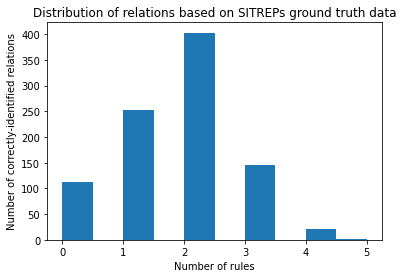

In [34]:
sitreps_positive_dist = [sum(row[1:]) for row in sitreps_gt_features if row[0]==1]    
sitreps_negative_dist = [sum(row[1:]) for row in sitreps_gt_features if row[0]==0]
import matplotlib.pyplot as plt
plt.hist(sitreps_positive_dist)
plt.xlabel('Number of rules')
plt.ylabel('Number of correctly-identified relations')
plt.title('Distribution of relations based on SITREPs ground truth data')
#plt.show()
plt.savefig("sitreps_positive_dist.pdf")

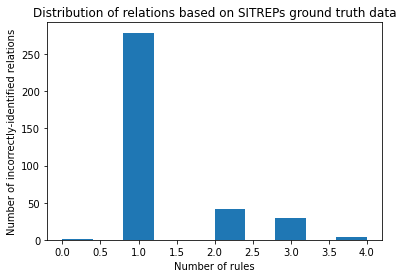

In [35]:
plt.hist(sitreps_negative_dist)
plt.xlabel('Number of rules')
plt.ylabel('Number of incorrectly-identified relations')
plt.title('Distribution of relations based on SITREPs ground truth data')
#plt.show()
plt.savefig("sitreps_negative_dist.pdf")

In [36]:
#gt_features_df = pd.DataFrame(gt_features, columns=["gt", "dep1", "dep2", "dep3", "const1", "const2", "const3", "co_dist", "dep_dist"])
sitreps_gt_features_df = pd.DataFrame(sitreps_gt_features, columns=["gt", "dep1", "dep2", "dep3", "const1", "const2", "const3", "co_dist", "dep_dist"])

In [37]:
sitreps_gt_features_df.to_csv('gt_features.csv')

In [38]:
from sklearn.model_selection import train_test_split
X = sitreps_gt_features_df.drop(["gt"], axis=1)
y = sitreps_gt_features_df["gt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((1033, 8), (259, 8))

In [39]:
# import SVC classifier
from sklearn.svm import SVC
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
# instantiate classifier with default hyperparameters
sitreps_svc=SVC() 

# fit classifier to training set
sitreps_svc.fit(X_train,y_train)

# make predictions on test set
y_pred=sitreps_svc.predict(X_test)

print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Model Precision score with default hyperparameters: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print('Model Recall score with default hyperparameters: {0:0.4f}'. format(recall_score(y_test, y_pred)))


Model accuracy score with default hyperparameters: 0.8340
Model Precision score with default hyperparameters: 0.8626
Model Recall score with default hyperparameters: 0.8971


In [40]:
from sklearn.model_selection import cross_val_score
import numpy as np
scores = cross_val_score(sitreps_svc, X, y, cv=10)
scores

array([0.86923077, 0.91538462, 0.89922481, 0.94573643, 0.8372093 ,
       0.92248062, 0.84496124, 0.84496124, 0.76744186, 0.69767442])

In [41]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.85 accuracy with a standard deviation of 0.07


In [42]:
recall = cross_val_score(sitreps_svc, X_train, y_train, cv=10, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(sitreps_svc, X_train, y_train, cv=10, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(sitreps_svc, X_train, y_train, cv=10, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.9017088174982911 [0.94805195 0.88311688 0.87012987 0.86842105 0.90789474 0.92105263
 0.90789474 0.90789474 0.92105263 0.88157895]
Precision 0.929131485129937 [0.96052632 0.94444444 0.98529412 0.91666667 0.90789474 0.90909091
 0.90789474 0.90789474 0.92105263 0.93055556]
F1 0.9148204794041025 [0.95424837 0.91275168 0.92413793 0.89189189 0.90789474 0.91503268
 0.90789474 0.90789474 0.92105263 0.90540541]


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73        84
           1       0.86      0.90      0.88       175

    accuracy                           0.83       259
   macro avg       0.81      0.80      0.81       259
weighted avg       0.83      0.83      0.83       259



In [44]:
## Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100) 
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

In [45]:
recall = cross_val_score(clf, X_train, y_train, cv=10, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.8990772385509228 [0.94805195 0.88311688 0.87012987 0.86842105 0.90789474 0.92105263
 0.90789474 0.90789474 0.90789474 0.86842105]
Precision 0.92892841289536 [0.96052632 0.94444444 0.98529412 0.91666667 0.90789474 0.90909091
 0.90789474 0.90789474 0.92       0.92957746]
F1 0.9133613225498355 [0.95424837 0.91275168 0.92413793 0.89189189 0.90789474 0.91503268
 0.90789474 0.90789474 0.91390728 0.89795918]


# Tweets

In [46]:
def rule_9(dep):
    if len(dep)>=2 and len(dep)<=4:
        if len(set(dep))==1 and dep[0]=="PROPN":
            return 1
    return 0

# def rule_10(dep):
#     if "VERB" in dep:
#         return 1
#     return 0

def rule_10(dep):
    ptn = ["VERB", "ADP"]
    if ptn[0] in dep or ptn[1] in dep or " ".join(ptn) in " ".join(dep):
        return 1
    return 0

def rule_11(dep):
    if "NOUN" in dep:
        return 1
    return 0

# def rule_11(dep):
#     ptn = ["NOUN","ADP"]
#     if " ".join(ptn) in " ".join(dep):
#         return 1
#     return 0    

def rule_12(const):
    if len(const)>=1 and len(const)<=3:
        if len(set(const))==1 and const[0]=="PROPN":
            return 1
    return 0

def rule_13(const):
    ptn = ["VERB", "ADP"]
    if ptn[0] in const or ptn[1] in const or " ".join(ptn) in " ".join(const):
        return 1
    return 0

def rule_14(const):
    ptn = ["NOUN", "ADP"]
    if " ".join(ptn) in " ".join(const):
        return 1
    return 0

def rule_15(co_dist):
    if co_dist in [1, 3, 4, 2, 0]:
        return 1
    return 0

def rule_16(dep_dist):
    if dep_dist in [3, 4, 5, 2, 6]:
        return 1
    return 0

In [47]:
# for gt data
tweets_tagged_tokens_path = "/content/drive/MyDrive/HADR - Pingjing and Ly/april_16/tweets_tagged_tokens.csv"
tweets_gt_relations_path = "/content/drive/MyDrive/HADR - Pingjing and Ly/april_16/tweets_gt_relations.csv"
tweets_tagged_tokens = pd.read_csv(tweets_tagged_tokens_path, keep_default_na=False, dtype={'human_annotation_ent_id': str}).values.tolist()
tweets_gt_relations = pd.read_csv(tweets_gt_relations_path, keep_default_na=False).values.tolist()

tweets_potential_rels = tagged_tokens_2_rels(tweets_tagged_tokens)

gt_tf_table = defaultdict(lambda: {})
for gt_rel in tweets_gt_relations:
    gt_tf_table[gt_rel[0]][frozenset([gt_rel[7], gt_rel[8]])] = gt_rel[2]

for rel in tweets_potential_rels:
    if frozenset([rel[7], rel[8]]) in gt_tf_table[rel[0]].keys():
        gt_rel_type = gt_tf_table[rel[0]][frozenset([rel[7], rel[8]])]
    else:
        gt_rel_type = "no_relation"

    rel[2] = gt_rel_type

tweets_gt_relations = potential_rels


In [48]:
tweets_gt_relations[0]

[0,
 'Hurricane Matthew was a powerful storm , first forming off the Cape Verde  \n islands on September 27 , 2016 .',
 'related',
 'Hurricane Matthew',
 'Cape Verde',
 'LOC',
 'GPE',
 '0',
 '1',
 'was a powerful storm , first forming off the',
 4,
 [2, 8, 9, 14],
 ['AUX', 'VERB', 'ADP', 'NOUN'],
 ['AUX', 'DET', 'ADJ', 'NOUN', 'PUNCT', 'ADV', 'VERB', 'ADP', 'DET']]

(array([116., 346.,   0., 189.,   0.,  65., 130.,   0.,  85.,   7.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

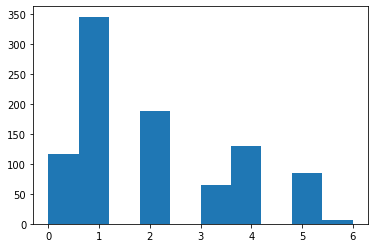

In [49]:
def tweets_features(tweets_gt_relations):
    tweets_gt_features = []
    for gt_rel in tweets_gt_relations:
        co_dist = len(gt_rel[9].split(" "))
        dep_dist = gt_rel[10]
        dep = gt_rel[12]
        const = gt_rel[13]
        tweets_gt_features.append([
            rule_0(gt_rel[2]), rule_9(dep), rule_10(dep), rule_11(dep), rule_12(const), rule_13(const), rule_14(const), rule_15(co_dist), rule_16(dep_dist)                
        ])
    return tweets_gt_features
tweets_gt_features = tweets_features(tweets_gt_relations)
tweets_positive_dist = [sum(row[1:]) for row in tweets_gt_features if row[0]==1]    
tweets_negative_dist = [sum(row[1:]) for row in tweets_gt_features if row[0]==0]
import matplotlib.pyplot as plt
plt.hist(tweets_positive_dist)

(array([288.,   0.,   5.,   0.,   0.,  22.,   0.,  29.,   0.,  10.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

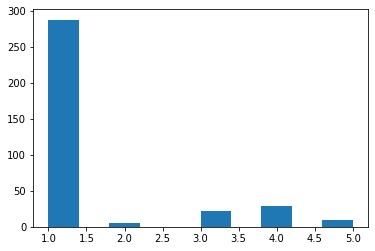

In [50]:
plt.hist(tweets_negative_dist)

In [51]:
tweets_gt_features_df = pd.DataFrame(tweets_gt_features, columns=["gt", "dep1", "dep2", "dep3", "const1", "const2", "const3", "co_dist", "dep_dist"])

In [52]:
from sklearn.model_selection import train_test_split
X = tweets_gt_features_df.drop(["gt"], axis=1)
y = tweets_gt_features_df["gt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((1033, 8), (259, 8))

In [53]:
tweets_svc=SVC() 

# fit classifier to training set
tweets_svc.fit(X_train,y_train)

# make predictions on test set
y_pred=tweets_svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Model Precision score with default hyperparameters: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print('Model Recall score with default hyperparameters: {0:0.4f}'. format(recall_score(y_test, y_pred)))


Model accuracy score with default hyperparameters: 0.7490
Model Precision score with default hyperparameters: 0.8716
Model Recall score with default hyperparameters: 0.7371


In [54]:
# Two models: tweets_svc, sitreps_svc

In [55]:
recall = cross_val_score(tweets_svc, X_train, y_train, cv=10, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(tweets_svc, X_train, y_train, cv=10, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(tweets_svc, X_train, y_train, cv=10, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.8243677375256322 [0.85714286 0.80519481 0.81818182 0.84210526 0.81578947 0.81578947
 0.85526316 0.82894737 0.85526316 0.75      ]
Precision 0.9321246135436019 [0.95652174 0.93939394 0.984375   0.92753623 0.91176471 0.91176471
 0.91549296 0.92647059 0.92857143 0.91935484]
F1 0.8745691977284882 [0.90410959 0.86713287 0.89361702 0.88275862 0.86111111 0.86111111
 0.88435374 0.875      0.89041096 0.82608696]


In [56]:
## Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100) 
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

In [57]:
recall = cross_val_score(clf, X_train, y_train, cv=10, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.8204203691045798 [0.85714286 0.80519481 0.81818182 0.84210526 0.80263158 0.81578947
 0.84210526 0.82894737 0.85526316 0.73684211]
Precision 0.9331402583377166 [0.95522388 0.93939394 0.984375   0.92753623 0.91044776 0.91176471
 0.91428571 0.92647059 0.92857143 0.93333333]
F1 0.8735493019798375 [0.90410959 0.86713287 0.89361702 0.88275862 0.86111111 0.86111111
 0.87671233 0.875      0.89041096 0.82352941]


# Feature analysis (this section can be skipped if you want to work on unseen data)

In [58]:
# co-occurrence
co = CoNetwork(sitreps_tagged_tokens, sitreps_gt_relations, NEGATIVE_FLAG)
co.co_occurrence_analysis()
co_occurrence_features = co.co_occurrence_analysis_raw_analysis()
co_occurrence_features

NameError: ignored

In [ ]:
# dep
dep = DepNetwork(sitreps_tagged_tokens, sitreps_gt_relations, NEGATIVE_FLAG)
dep.dependency_analysis()
dep.dependency_analysis_raw_analysis()
dep.dep_patterns()

In [ ]:
# const
# notes, I made some change to the output format
const = ConstNetwork(tagged_tokens, gt_relations, NEGATIVE_FLAG)
const.const_analysis_raw_analysis()

In [ ]:
# notes: new update-you do not need to add ent1 and ent2, and the approach will do an exact match here for the in-between pattern. 
example_pattern = ["ADV", "VERB", "ADJ", "ADP"]
const.const_patterns(example_pattern)

# ner results

In [18]:
# from raw text to tagged tokens 
# unite or intersect different tagged tokens results
raw_text = "/content/drive/MyDrive/HADR - Pingjing and Ly/Raw text/groundtruth_tweets.txt"
with open(raw_text) as f:
    data = f.read()

In [19]:
flairner = FlairNER(data)
sents = flairner.sentence_segmentation()

In [20]:
flair_tts, flair_rels = flairner.generate_tokens_n_rels(sents[:])

 98%|█████████▊| 697/712 [06:55<00:08,  1.68it/s]


KeyboardInterrupt: ignored

In [ ]:
sents[100]

In [21]:
spacyner = SpacyNER(data)
spacy_tts, spacy_rels = spacyner.generate_tokens_n_rels(sents[:])

100%|██████████| 712/712 [00:14<00:00, 48.14it/s]


In [13]:
# experiment different combinations
#s_f_i = spacy_flair_intersection(spacy_tts, flair_tts)
#s_f_u = spacy_flair_union(spacy_tts, flair_tts)

In [22]:
spacy_df = pd.DataFrame(spacy_tts).to_csv('heuristics_tweets_tagged_token_spacy.csv')

# Unseen data analysis

In [68]:
# from tagged tokens to network
irma_tokens_path = "/content/drive/MyDrive/HADR - Pingjing and Ly/tagged_tokens_unseen/heuristics_sitreps_tagged_tokens_intersection.csv"
irma_tokens = pd.read_csv(irma_tokens_path, keep_default_na=False, index_col=False).values.tolist()
irma_tokens = [row[1:] for row in irma_tokens]

In [78]:
irma_sitreps_rels = tagged_tokens_2_rels(irma_tokens)
irma_sitreps_rels[:10]

[[0,
  'Hurricane Matthew was a powerful storm , first forming off the Cape Verde islands on September 27 , 2016 .',
  'no_relation',
  'Cape Verde',
  '',
  'LOC',
  '',
  '0_2',
  '',
  '',
  'no_path_found',
  'no_path_found',
  'no_path_found',
  ''],
 [1,
  'When the storm reached the Caribbean it had intensified to a Category 5 hurricane on October 1 .',
  'no_relation',
  'Caribbean',
  '',
  'LOC',
  '',
  '1_0',
  '',
  '',
  'no_path_found',
  'no_path_found',
  'no_path_found',
  ''],
 [2,
  'Matthew then made landfall in Cuba and Haiti causing tremendous damage and loss of life , especially in Haiti where nearly 900 were reported killed by the storm .',
  '',
  'Cuba',
  'Haiti',
  'GPE',
  'GPE',
  '2_0',
  '2_1',
  'and',
  0,
  [],
  [],
  ['CCONJ']],
 [2,
  'Matthew then made landfall in Cuba and Haiti causing tremendous damage and loss of life , especially in Haiti where nearly 900 were reported killed by the storm .',
  '',
  'Cuba',
  'Haiti',
  'GPE',
  'GPE',
  '2_

In [79]:
# notes: change to tweets_features for tweets data
irma_sitreps_features = sitreps_features(irma_sitreps_rels)

In [80]:
irma_sitreps_features_df = pd.DataFrame(irma_sitreps_features, columns=["ignore_rel", "dep1", "dep2", "dep3", "const1", "const2", "const3", "co_dist", "dep_dist"])

In [81]:
X_test = irma_sitreps_features_df.drop(["ignore_rel"], axis=1)

In [82]:
# Note: change to tweets_svc for tweets data
y_pred=sitreps_svc.predict(X_test)

In [83]:
for i in range(len(y_pred)):
    irma_sitreps_rels[i][2] = y_pred[i]

In [84]:
irma_sitreps_rels_pd = pd.DataFrame(irma_sitreps_rels).to_csv('heuristics_sitreps_rels.csv')

In [ ]:
positive_irma_sitreps_rels_pd = irma_sitreps_rels_pd[irma_sitreps_rels_pd["rel_type"]==1]

TypeError: ignored

In [ ]:
from pyvis.network import Network
import networkx as nx

In [ ]:
net = Network(notebook=True)
G = nx.from_pandas_edgelist(positive_irma_sitreps_rels_pd, source='ent1_text', target='ent2_text')

In [ ]:
net.from_nx(G)

In [ ]:
import IPython
IPython.display.HTML(filename='example.html')